In [13]:
import scipy.io
import numpy as np


In [27]:
#Load the .mat file
data = scipy.io.loadmat('./SEED/SEED_EEG/Preprocessed_EEG/1_20131027.mat')

#Extrct EEg data and labels
eeg_segments = [data[f'djc_eeg{i}'] for i in range(1, 16)]
# labels = data['labels'].flatten()

#convert to numpy arrays for processing 
# eeg_data = np.stack(eeg_segments, axis=0)
print(data.keys())
print(eeg_segments)
for i, eeg in enumerate(eeg_segments, start=1):
    print(f"djc_eeg{i} shape: {eeg.shape}")

# print(labels)
# print(f"EEG Data shape: {eeg_data.shape}")
# print(f"Labels Shape: {labels.shape}")

dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15'])
[array([[-11.62290573, -16.21246338, -17.13633537, ..., -46.10419273,
        -51.05137825, -43.6604023 ],
       [ 14.93096352,   8.07642937,   8.19563866, ..., -24.31869507,
        -27.74596214, -22.5007534 ],
       [ 38.05756569,  25.57039261,  37.99796104, ..., -54.06141281,
        -58.29334259, -48.63739014],
       ...,
       [ 24.25909042,  15.49720764,  21.51727676, ...,   7.62939453,
         17.34495163,  -8.5234642 ],
       [ 26.82209015,  27.77576447,  26.70288086, ...,  25.74920654,
         35.76278687,  16.00384712],
       [ 29.77252007,  33.55741501,  30.39836884, ...,  20.02716064,
         30.15995026,  12.15934753]]), array([[-57.6376915 , -41.15700722, -41.45503044, ..., -16.65949821,
        -28.58042717, -35.04753113],
 

In [44]:
import os

folder_path = './SEED/SEED_EEG/Preprocessed_EEG'

# Initialize variables
all_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]
smallest_length = float('inf')

# Step 1: Find the smallest trial length
for file_name in all_files:
    file_path = os.path.join(folder_path, file_name)
    data = scipy.io.loadmat(file_path)
    
    # Iterate through trials in the file
    for i in range(1, 16):
        key = f'djc_eeg{i}'
        if key in data:
            trial = data[key]
            smallest_length = min(smallest_length, trial.shape[1])
        
print(f"Smallest trial length: {smallest_length}")

Smallest trial length: 37001


In [47]:
from scipy.interpolate import interp1d

# Function to resample a trial to a fixed length
def resample_trial(trial, target_length):
    channels, time_points = trial.shape
    resampled = np.zeros((channels, target_length))
    for ch in range(channels):
        interp = interp1d(np.linspace(0,1,time_points), trial[ch,:], kind='linear') 
        resampled[ch,:] = interp(np.linspace(0,1,target_length))
    return resampled

In [48]:
def normalize_eeg(data):
    mean = np.mean(data, axis=(0,2), keepdims=True)
    std = np.std(data, axis=(0,2), keepdims=True)
    return (data - mean) / std

In [52]:
# Initialize lists for resampled and normalized data
all_data, all_labels = [], []
all_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]
for file_name in all_files:
    data = scipy.io.loadmat(os.path.join(folder_path, file_name))
    labels = np.array([1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1])
    for i in range(1, 16):
        key = f'djc_eeg{i}'
        if key in data:
            trial = data[key]
            resampled = resample_trial(trial, smallest_length)
            all_data.append(resampled)
            all_labels.append(labels[i - 1])
all_data = np.stack(all_data, axis=0)
all_data = normalize_eeg(all_data)
all_labels = np.array(all_labels)
    
print(f"Final Data shape: {all_data.shape}")
print(f"Final Labels shape: {all_labels.shape}")



Final Data shape: (45, 62, 37001)
Final Labels shape: (45,)


In [46]:
import os
import scipy.io
import numpy as np
from scipy.interpolate import interp1d

# Find smallest trial length
def find_smallest_length(folder_path):
    smallest_length = float('inf')
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]
    for file_name in all_files:
        data = scipy.io.loadmat(os.path.join(folder_path, file_name))
        for i in range(1, 16):
            key = f'djc_eeg{i}'
            if key in data:
                trial = data[key]
                smallest_length = min(smallest_length, trial.shape[1])
    return smallest_length

# Resample trials
def resample_trial(trial, target_length):
    channels, time_points = trial.shape
    resampled = np.zeros((channels, target_length))
    for ch in range(channels):
        interp = interp1d(np.linspace(0, 1, time_points), trial[ch, :], kind='linear')
        resampled[ch, :] = interp(np.linspace(0, 1, target_length))
    return resampled

# Stratified normalization
def stratified_normalization(data):
    mean = np.mean(data, axis=(0, 2), keepdims=True)
    std = np.std(data, axis=(0, 2), keepdims=True)
    return (data - mean) / std

# Prepare data
def prepare_data(folder_path, target_length):
    all_data, all_labels = [], []
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]
    for file_name in all_files:
        data = scipy.io.loadmat(os.path.join(folder_path, file_name))
        labels = np.array([1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1])
        for i in range(1, 16):
            key = f'djc_eeg{i}'
            if key in data:
                trial = data[key]
                resampled = resample_trial(trial, target_length)
                all_data.append(resampled)
                all_labels.append(labels[i - 1])
    all_data = np.stack(all_data, axis=0)
    all_data = stratified_normalization(all_data)
    return all_data, np.array(all_labels)

# Main processing
folder_path = './SEED/SEED_EEG/Preprocessed_EEG'
smallest_length = find_smallest_length(folder_path)
all_data, all_labels = prepare_data(folder_path, smallest_length)
print(f"Prepared Data Shape: {all_data.shape}, Labels Shape: {all_labels.shape}")


Prepared Data Shape: (45, 62, 37001), Labels Shape: (45,)


In [53]:
def sample_segments(data, labels, time_length=30 * 200, time_step=15 * 200):
    segments, segment_labels = [], []
    for trial, label in zip(data, labels):
        trial_length = trial.shape[-1]
        for start in range(0, trial_length - time_length + 1, time_step):
            segment = trial[:, start:start + time_length]
            segments.append(segment)
            segment_labels.append(label)
    return np.array(segments), np.array(segment_labels)

time_length = 30 * 200  # 30 seconds * 200 Hz
time_step = 15 * 200    # 15 seconds * 200 Hz
sampled_data, sampled_labels = sample_segments(all_data, all_labels)
print(f"Sampled Data Shape: {sampled_data.shape}, Sampled Labels Shape: {sampled_labels.shape}")


Sampled Data Shape: (495, 62, 6000), Sampled Labels Shape: (495,)


In [81]:
import torch
import torch.nn as nn

class BaseEncoder(nn.Module):
    def __init__(self, input_channels, spatial_filters=16, temporal_filters=16):
        super(BaseEncoder, self).__init__()
        self.spatial_conv = nn.Conv1d(input_channels, spatial_filters, kernel_size=1)
        self.temporal_conv = nn.Conv1d(spatial_filters, temporal_filters, kernel_size=60, padding=30)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)  # Pool across the time dimension
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.spatial_conv(x))  # Spatial convolution
        x = self.relu(self.temporal_conv(x))  # Temporal convolution
        x = self.avg_pool(x).squeeze(-1)  # Reduce time dimension
        return x  # Shape: [batch_size, temporal_filters]


In [82]:
class Projector(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(Projector, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )

    def forward(self, x):
        return self.fc(x)  # Shape: [batch_size, latent_dim]


In [83]:
class ContrastiveModel(nn.Module):
    def __init__(self, input_channels, temporal_filters, latent_dim=64):
        super(ContrastiveModel, self).__init__()
        self.encoder = BaseEncoder(input_channels, temporal_filters=temporal_filters)
        self.projector = Projector(input_dim=temporal_filters, latent_dim=latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)  # Shape: [batch_size, temporal_filters]
        projected = self.projector(encoded)  # Shape: [batch_size, latent_dim]
        return projected


In [86]:
contrastive_model = ContrastiveModel(input_channels=sampled_data.shape[1],temporal_filters=16, latent_dim=64)

batch_A = torch.tensor(batch_A, dtype=torch.float32)  # Shape: [batch_size, channels, time_points]
batch_B = torch.tensor(batch_B, dtype=torch.float32)  # Shape: [batch_size, channels, time_points]

z_A = contrastive_model(batch_A)  # Shape: [batch_size, latent_dim]
z_B = contrastive_model(batch_B)  # Shape: [batch_size, latent_dim]

print(f"z_A Shape: {z_A.shape}, z_B Shape: {z_B.shape}")


C:\Users\hamza\AppData\Local\Temp\ipykernel_8984\1233950057.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_A = torch.tensor(batch_A, dtype=torch.float32)  # Shape: [batch_size, channels, time_points]
C:\Users\hamza\AppData\Local\Temp\ipykernel_8984\1233950057.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_B = torch.tensor(batch_B, dtype=torch.float32)  # Shape: [batch_size, channels, time_points]


z_A Shape: torch.Size([32, 64]), z_B Shape: torch.Size([32, 64])


In [87]:
import torch.nn.functional as F

def contrastive_loss(z_i, z_j, temperature=0.5):
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)
    similarity_matrix = torch.matmul(z_i, z_j.T) / temperature
    labels = torch.arange(z_i.size(0)).to(z_i.device)
    return F.cross_entropy(similarity_matrix, labels)


Using device: cuda
Epoch 1, Loss: 3.4575
Epoch 2, Loss: 3.4405
Epoch 3, Loss: 3.4038
Epoch 4, Loss: 3.4066
Epoch 5, Loss: 3.3837
Epoch 6, Loss: 3.3719
Epoch 7, Loss: 3.3429
Epoch 8, Loss: 3.3695
Epoch 9, Loss: 3.2749
Epoch 10, Loss: 3.3172
Epoch 11, Loss: 3.2652
Epoch 12, Loss: 3.2086
Epoch 13, Loss: 3.2019
Epoch 14, Loss: 3.1635
Epoch 15, Loss: 3.0581
Epoch 16, Loss: 3.0611
Epoch 17, Loss: 2.9858
Epoch 18, Loss: 2.9914
Epoch 19, Loss: 3.0092
Epoch 20, Loss: 2.9032
Epoch 21, Loss: 2.8116
Epoch 22, Loss: 2.7210
Epoch 23, Loss: 2.7030
Epoch 24, Loss: 2.7260
Epoch 25, Loss: 2.5461
Epoch 26, Loss: 2.5538
Epoch 27, Loss: 2.5231
Epoch 28, Loss: 2.5259
Epoch 29, Loss: 2.5446
Epoch 30, Loss: 2.4535
Epoch 31, Loss: 2.5324
Epoch 32, Loss: 2.3871
Epoch 33, Loss: 2.4183
Epoch 34, Loss: 2.4723
Epoch 35, Loss: 2.3177
Epoch 36, Loss: 2.3386
Epoch 37, Loss: 2.3248
Epoch 38, Loss: 2.4643
Epoch 39, Loss: 2.3295
Epoch 40, Loss: 2.3512
Epoch 41, Loss: 2.3174
Epoch 42, Loss: 2.2985
Epoch 43, Loss: 2.3259
E

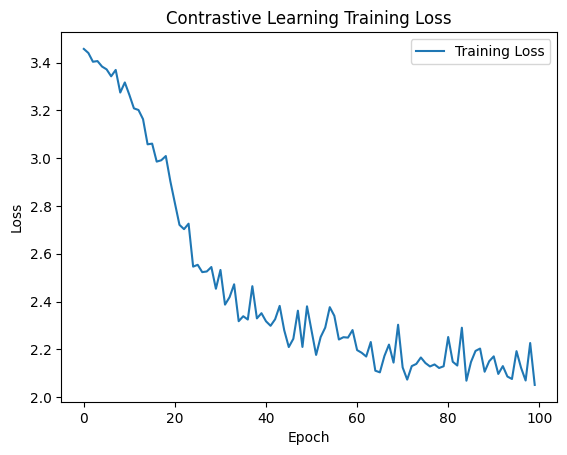

In [98]:
# Initialize the model
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_channels = sampled_data.shape[1]
temporal_filters = 16  # Match the `temporal_filters` in the encoder
latent_dim = 64

contrastive_model = ContrastiveModel(input_channels=input_channels, temporal_filters=temporal_filters, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=0.0007, weight_decay=0.015)

# Training loop
losses = []
epochs = 100

for epoch in range(epochs):
    contrastive_model.train()
    total_loss = 0

    # Generate minibatches
    batch_A, batch_B = data_sampler(sampled_data, sampled_labels)  # Shape: [batch_size, channels, time_points]
    batch_A = torch.tensor(batch_A, dtype=torch.float32).to(device)
    batch_B = torch.tensor(batch_B, dtype=torch.float32).to(device)

    # Forward pass
    z_A = contrastive_model(batch_A)  # Shape: [batch_size, latent_dim]
    z_B = contrastive_model(batch_B)  # Shape: [batch_size, latent_dim]

    # Compute contrastive loss
    loss = contrastive_loss(z_A, z_B)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")
    
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Learning Training Loss")
plt.legend()
plt.show()


In [99]:
print(f"Batch A Shape: {batch_A.shape}")  # Expected: [batch_size, channels, time_points]
print(f"Encoder Output Shape: {z_A.shape}")  # Expected: [batch_size, latent_dim]
print(f"Contrastive Loss Input Shapes: z_A={z_A.shape}, z_B={z_B.shape}")  # Expected: [batch_size, latent_dim]


Batch A Shape: torch.Size([32, 62, 6000])
Encoder Output Shape: torch.Size([32, 64])
Contrastive Loss Input Shapes: z_A=torch.Size([32, 64]), z_B=torch.Size([32, 64])


In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Split the data into training and test sets
de_features_train, de_features_test, labels_train, labels_test = train_test_split(sampled_data, sampled_labels, test_size=0.2, random_state=42)

classifier = EmotionClassifier(input_dim=64, num_classes=3).to(device)

# Evaluate on test set
classifier.eval()
with torch.no_grad():
    logits = classifier(torch.tensor(de_features_test, dtype=torch.float32).to(device))
    predictions = torch.argmax(logits, axis=1).cpu().numpy()  # Move to CPU for evaluation
    labels_test = labels_test.cpu().numpy()  # Ensure labels are also on CPU

# Compute confusion matrix
cm = confusion_matrix(labels_test, predictions, labels=[-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Compute accuracy
accuracy = accuracy_score(labels_test, predictions)
print(f"Accuracy: {accuracy:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6138x6000 and 64x128)

In [ ]:
# Combined visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training loss
axes[0].plot(losses, label="Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Contrastive Learning Training Loss")
axes[0].legend()

# Plot confusion matrix
disp.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()
